In [5]:
# 构建语料库，每行包括中文、英文（解码器输入）和翻译成英文后的目标输出3共和句子
sentences = [
    ['咖哥 喜欢 小冰', '<sos> KaGe likes XiaoBing', 'KaGe likes XiaoBing <eos>'],
    ['我 爱 学习 人工智能', '<sos> I love studying AI', 'I love studying AI <eos>'],
    ['深度学习 改变 世界', '<sos> DL changed the world', 'DL changed the world <eos>'],
    ['自然 语言 处理 很 强大', '<sos> NLP is so powerful', 'NLP is so powerful <eos>'],
    ['神经网络 非常 复杂', '<sos> Neural-Nets are complex', 'Neural-Nets are complex <eos>'],
]
word_list_cn, word_list_en = [], []  # 中英文词汇表
# 遍历每一个句子并将单词添加到对应的词汇表中
for cn, en, en2 in sentences:
    word_list_cn.extend(cn.split())
    word_list_en.extend(en.split())
    word_list_en.extend(en2.split())
# 去重
word_list_cn = list(set(word_list_cn))
word_list_en = list(set(word_list_en))
# 构建单词到索引的映射
word2idx_cn = {w: i for i, w in enumerate(word_list_cn)}
word2idx_en = {w: i for i, w in enumerate(word_list_en)}
# 构建索引到单词的映射
idx2word_cn = {i: w for i, w in enumerate(word_list_cn)}
idx2word_en = {i: w for i, w in enumerate(word_list_en)}
# 计算词汇表的大小
vocab_size_cn = len(word_list_cn)
vocab_size_en = len(word_list_en)
print("句子数量: ", len(sentences))
print("中文词汇表大小: ", vocab_size_cn)
print("英文词汇表大小: ", vocab_size_en)
print("中文词汇表: ", word2idx_cn)
print("英文词汇表: ", word2idx_en)

句子数量:  5
中文词汇表大小:  18
英文词汇表大小:  20
中文词汇表:  {'复杂': 0, '非常': 1, '自然': 2, '改变': 3, '我': 4, '喜欢': 5, '世界': 6, '处理': 7, '强大': 8, '咖哥': 9, '爱': 10, '学习': 11, '神经网络': 12, '语言': 13, '很': 14, '小冰': 15, '人工智能': 16, '深度学习': 17}
英文词汇表:  {'studying': 0, 'DL': 1, 'KaGe': 2, 'I': 3, 'AI': 4, 'love': 5, 'is': 6, 'NLP': 7, 'complex': 8, 'are': 9, '<eos>': 10, 'powerful': 11, 'likes': 12, 'XiaoBing': 13, 'changed': 14, 'Neural-Nets': 15, '<sos>': 16, 'so': 17, 'world': 18, 'the': 19}


In [6]:
import numpy as np # 导入 numpy
import torch # 导入 torch
import random # 导入 random 库
# 定义一个函数，随机选择一个句子和词汇表生成输入、输出和目标数据
def make_data(sentences):
    # 随机选择一个句子进行训练
    random_sentence = random.choice(sentences)
    # 将输入句子中的单词转换为对应的索引
    encoder_input = np.array([[word2idx_cn[n] for n in random_sentence[0].split()]])
    # 将输出句子中的单词转换为对应的索引
    decoder_input = np.array([[word2idx_en[n] for n in random_sentence[1].split()]])
    # 将目标句子中的单词转换为对应的索引
    target = np.array([[word2idx_en[n] for n in random_sentence[2].split()]])
    # 将输入、输出和目标批次转换为 LongTensor
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input)
    target = torch.LongTensor(target)
    return encoder_input, decoder_input, target 
# 使用 make_data 函数生成输入、输出和目标张量
encoder_input, decoder_input, target = make_data(sentences)
for s in sentences: # 获取原始句子
    if all([word2idx_cn[w] in encoder_input[0] for w in s[0].split()]):
        original_sentence = s
        break
print(" 原始句子：", original_sentence) # 打印原始句子
print(" 编码器输入张量的形状：", encoder_input.shape)  # 打印输入张量形状
print(" 解码器输入张量的形状：", decoder_input.shape) # 打印输出张量形状
print(" 目标张量的形状：", target.shape) # 打印目标张量形状
print(" 编码器输入张量：", encoder_input) # 打印输入张量
print(" 解码器输入张量：", decoder_input) # 打印输出张量
print(" 目标张量：", target) # 打印目标张量

 原始句子： ['深度学习 改变 世界', '<sos> DL changed the world', 'DL changed the world <eos>']
 编码器输入张量的形状： torch.Size([1, 3])
 解码器输入张量的形状： torch.Size([1, 5])
 目标张量的形状： torch.Size([1, 5])
 编码器输入张量： tensor([[17,  3,  6]])
 解码器输入张量： tensor([[16,  1, 14, 19, 18]])
 目标张量： tensor([[ 1, 14, 19, 18, 10]])


In [7]:
# 定义Attention类
import torch.nn as nn
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
    
    def forward(self, decoder_context, encoder_context):
        # 计算解码器上下文和编码器上下文之间的点积，得到注意力分数
        scores = torch.bmm(decoder_context, encoder_context.transpose(-2, -1))
        # 计算注意力分数的softmax
        attn_weights = nn.functional.softmax(scores, dim=-1)
        # 计算注意力加权后的编码器上下文
        context = torch.bmm(attn_weights, encoder_context)
        return context, attn_weights


In [8]:
# 定义编码器类和解码器类
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size  # 隐藏层大小
        self.embedding = nn.Embedding(input_size, hidden_size)  # 词嵌入层
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)  # RNN层
    def forward(self, input, hidden):
        embedded = self.embedding(input)  # 词嵌入
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden
# 定义解码器类
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size  # 隐藏层大小
        self.embedding = nn.Embedding(output_size, hidden_size)  # 词嵌入层
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)  # RNN层
        self.attention = Attention()  # 注意力层
        self.out = nn.Linear(2 * hidden_size, output_size)  # 输出层
    def forward(self, input, hidden, enc_output):
        embedded = self.embedding(input)  # 词嵌入
        rnn_output, hidden = self.rnn(embedded, hidden)
        context, attn_weights = self.attention(rnn_output, enc_output)
        dec_output = torch.cat((rnn_output, context), -1)  # 拼接
        dec_output = self.out(dec_output)  # 输出
        return dec_output, hidden, attn_weights
n_hidden = 128  # 隐藏层大小
# 创建编码器和解码器
encoder = Encoder(vocab_size_cn, n_hidden)
decoder = Decoder(n_hidden, vocab_size_en)
print("编码器结构：", encoder)
print("解码器结构：", decoder)

编码器结构： Encoder(
  (embedding): Embedding(18, 128)
  (rnn): RNN(128, 128, batch_first=True)
)
解码器结构： Decoder(
  (embedding): Embedding(20, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (attention): Attention()
  (out): Linear(in_features=256, out_features=20, bias=True)
)


In [9]:
# 组合编码器和解码器
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder  # 编码器
        self.decoder = decoder  # 解码器
    def forward(self, encoder_input, hidden, decoder_input):
        # 使输入序列通过编码器冰获取输出和隐藏状态
        encoder_output, encoder_hidden = self.encoder(encoder_input, hidden)
        # 将编码器的隐藏状态作为解码器的初始隐藏状态
        decoder_hidden = encoder_hidden
        # 使解码器的输入序列通过解码器并获取输出
        decoder_output, _, attn_weights = self.decoder(decoder_input, decoder_hidden, encoder_output)
        return decoder_output, attn_weights
# 创建Seq2Seq模型
model = Seq2Seq(encoder, decoder)
print("Seq2Seq模型结构：", model)

Seq2Seq模型结构： Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18, 128)
    (rnn): RNN(128, 128, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(20, 128)
    (rnn): RNN(128, 128, batch_first=True)
    (attention): Attention()
    (out): Linear(in_features=256, out_features=20, bias=True)
  )
)


In [10]:
# 定义训练函数
def train_seq2seq(model, criterion, optimizer, epochs):
    for epoch in range(epochs):
        encoder_input, decoder_input, target = make_data(sentences)  # 生成输入、输出和目标数据
        hidden = torch.zeros(1, encoder_input.size(0), n_hidden)  # 初始化隐藏状态
        optimizer.zero_grad()
        output, _ = model(encoder_input, hidden, decoder_input)
        loss = criterion(output.view(-1, vocab_size_en), target.view(-1))
        if (epoch + 1) % 100 == 0:
            print("Epoch: %d, Loss: %1.04f" % (epoch + 1, loss.item()))
        loss.backward()
        optimizer.step()
# 训练模型
epochs = 400
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_seq2seq(model, criterion, optimizer, epochs)

Epoch: 100, Loss: 0.0226
Epoch: 200, Loss: 0.0077
Epoch: 300, Loss: 0.0049
Epoch: 400, Loss: 0.0037


In [11]:
# 可视化注意力
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 显示负号
def visualize_attention(source_sentences, predicetd_sentence, attn_weights):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(attn_weights, annot=True, xticklabels=source_sentences.split(), yticklabels=predicetd_sentence, cmap='Greens')  # 热力图
    plt.xlabel("源序列")
    plt.ylabel("目标序列")
    plt.title("注意力热力图")

咖哥 喜欢 小冰 -> KaGe likes XiaoBing
自然 语言 处理 很 强大 -> NLP is is powerful is
我 爱 学习 人工智能 -> I love studying AI
小冰 喜欢 咖哥 -> KaGe likes XiaoBing


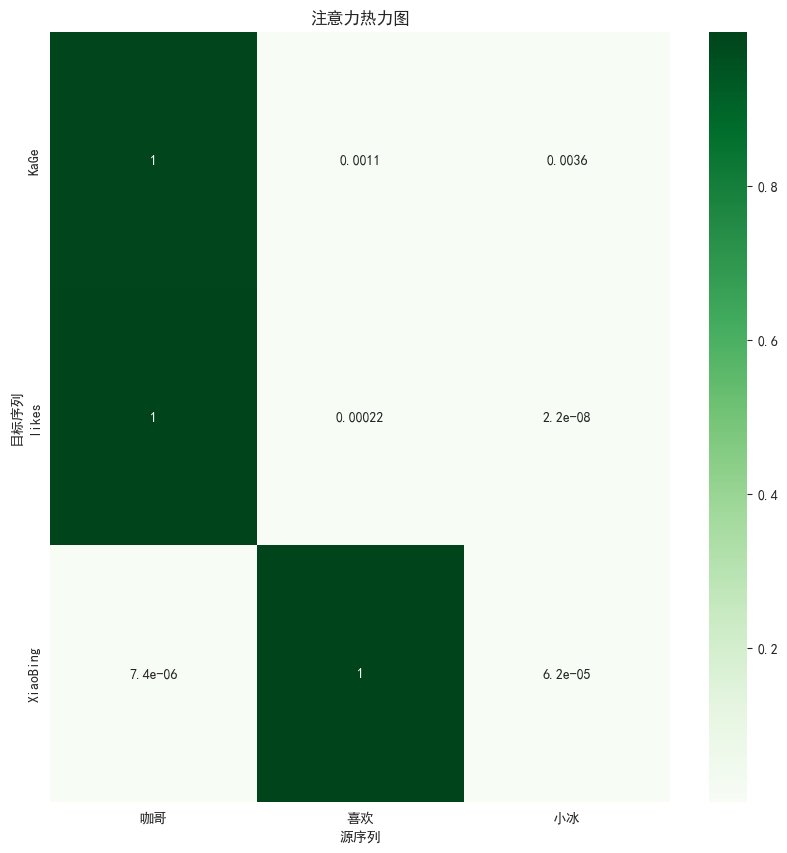

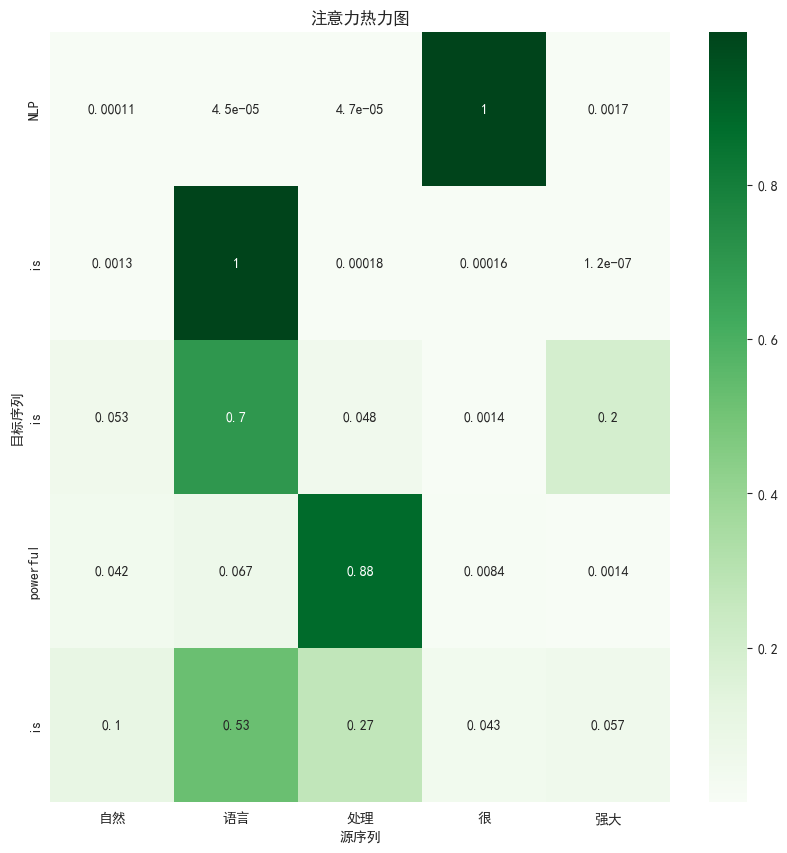

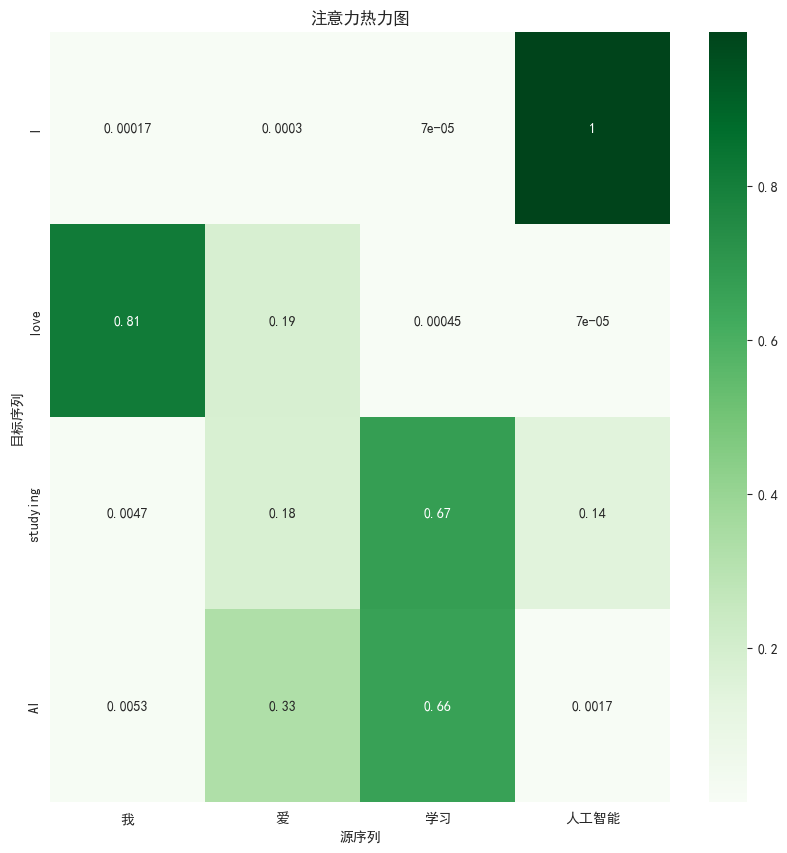

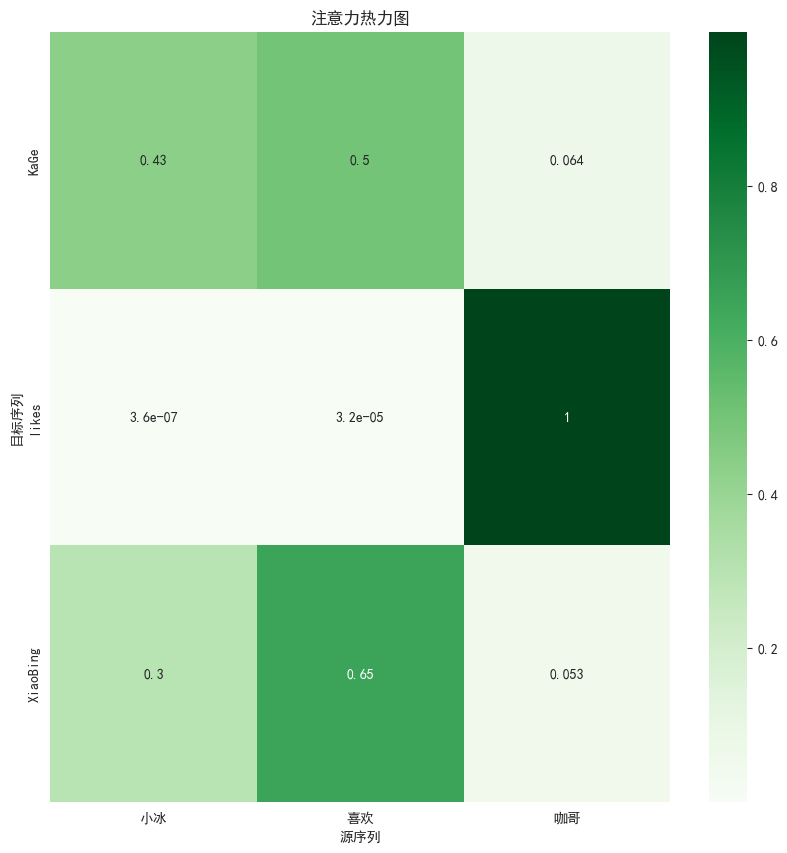

In [12]:
# 定义预测函数
def test_seq2seq(model, source_sentences):
    # 将输入句子转化为索引
    encoder_input = np.array([[word2idx_cn[w] for w in source_sentences.split()]])
    # 构建输出句子的索引，以'<sos>'开始，后面跟'<eos>'，长度与输入句子相同
    decoder_input = np.array([[word2idx_en['<sos>']] + [word2idx_en['<eos>']] * (len(encoder_input[0]) - 1)])
    # 将输入、输出转化为LongTensor
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input)
    hidden = torch.zeros(1, encoder_input.size(0), n_hidden)  # 初始化隐藏状态
    predicted, attn_weights = model(encoder_input, hidden, decoder_input)  # 预测
    predicted = predicted.data.max(2, keepdim=True)[1]  # 获取预测结果
    # 打印输入结果何预测结果
    print(source_sentences, '->', ' '.join([idx2word_en[i.item()] for i in predicted.squeeze()]))
    # 可视化注意力权重
    attn_weights = attn_weights.squeeze(0).cpu().detach().numpy()
    visualize_attention(source_sentences, [idx2word_en[i.item()] for i in predicted.squeeze()], attn_weights)
# 测试模型
test_seq2seq(model, '咖哥 喜欢 小冰')
test_seq2seq(model, "自然 语言 处理 很 强大")
test_seq2seq(model, '我 爱 学习 人工智能')
test_seq2seq(model, '小冰 喜欢 咖哥')